<a href="https://colab.research.google.com/github/GHC-av/DL_project/blob/main/DL_project_ModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - Final Project
## Models Training

In [ ]:
import cv2
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import keras
from keras.models import Sequential
from keras import layers
from keras import models
import sklearn
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
#from keras.preprocessing.image import array_to_img
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import CSVLogger

In [ ]:
#from tensorflow.keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Obtain your data and find a way to load it into Python and (3) detailed description of the dataset
e.g. size, number of samples, histograms, etc.

The images were downloaded on my local disk. The X-ray images are stored in a folder called "chest_xray", the folder has 3 subfolders: train, test. Each of these 2 folders has 2 subfolders: Pneumonia, Normal. The images are located in here.

*Note*: in the [original dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/notebooks), the validation set is very small (only 16 examples). For this reason I decided to use this alternative [version](https://www.kaggle.com/tolgadincer/labeled-chest-xray-images) where the validation data set have been merged with the train set. I will simply specify the validation holdout set during the model training.

First, we load the images

In [ ]:
labels = ['NORMAL', 'PNEUMONIA'] # I want 1 = Pneumonia
img_size = 150
def get_im(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label) # 0 or 1
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            #cv2.IMREAD_COLOR try this instead of cv2.IMREAD_GRAYSCALE
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr, class_num])
    return np.array(data)

In [ ]:
train_path = "/content/drive/My Drive/chest_xray/train/"
test_path =  "/content/drive/My Drive/chest_xray/test/"

In [ ]:
#os.listdir("/content/drive/My Drive/")

In [ ]:
train = get_im(train_path)
test = get_im(test_path)

In [ ]:
type(train)

numpy.ndarray

In [ ]:
train.shape

(5249, 2)

In [ ]:
print( f'There are {len(train)} images in our train dataset')
print( f'There are {len(test)} images in our train dataset')

There are 5249 images in our train dataset
There are 624 images in our train dataset


The number of Pneumonia images is three times the number of images labelled as normal. This might be a sign of an imbalanced data set.

Labelling:
- 0 = Normal
- 1 = Pneumonia

In [ ]:
print(f"binary value {train[0][1]} refers to {labels[train[0][1]]}")
print(f"binary value {train[-1][1]} refers to {labels[train[-1][1]]}")

binary value 0 refers to NORMAL
binary value 1 refers to PNEUMONIA


Normal images count in training set: 1366
Pneumonia images count in training set: 3883


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


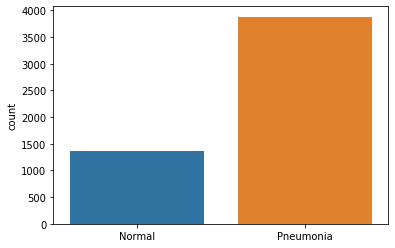

In [ ]:
l = []
count_pneumonia = 0
count_normal=0

for i in train:
    if(i[1] == 1):
        count_pneumonia +=1
        l.append("Pneumonia")
    else:
        l.append("Normal")
        count_normal +=1

print("Normal images count in training set: " + str(count_normal))
print("Pneumonia images count in training set: " + str(count_pneumonia))

sns.countplot(l)  

In [ ]:
pneu_weight = (1 / pneu_count)*(tot_train_img)/2.0
norm_weight = (1 / norm_count)*(tot_train_img)/2.0

# Order of the classes, mapped to the label indices, is alphanumeric
class_weight = {0: norm_weight, 1: pneu_weight}

print('Weight for class pneumonia: {:.2f}'.format(pneu_weight)) #0.68
print('Weight for class normal: {:.2f}'.format(norm_weight)) #1.92

Weight for class pneumonia: 0.68
Weight for class normal: 1.92


As a consequence of the way we read the files, normal images are in the first rows of our train data set while Pneumonia images are at the bottom.

Text(0.5, 1.0, 'PNEUMONIA')

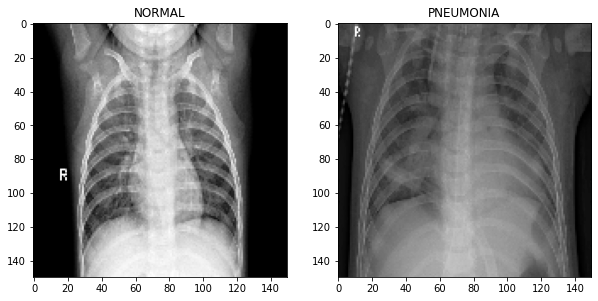

In [ ]:
# Plot the first and the last image of the train set.
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(train[0][0], cmap='Greys_r')
a1.set_title(labels[train[0][1]])

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(train[-1][0], cmap='Greys_r')
a2.set_title(labels[train[-1][1]])

## 2. Process your data with a simple baseline model

For example, if your project involves classification a natural baseline model would be logistic regression.

Split the train and test set in x (image) and y (label)

In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

for i in train:
    image = i[0]
    lab = i[1]
    x_train.append(image)
    y_train.append(lab)

for i in test:
    image = i[0]
    lab = i[1]
    x_test.append(image)
    y_test.append(lab)

Normalize the images and reshape them so that we can feed them to our model

In [ ]:
x_train = np.array(x_train)/255
x_test = np.array(x_test)/255

In [ ]:
x_train = x_train.reshape(-1, img_size*img_size)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size*img_size)
y_test = np.array(y_test)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5249, 22500)
(5249,)
(624, 22500)
(624,)


Now we build a logistic model as baseline.

In [ ]:
model_base= keras.Sequential([
                              layers.Dense(1, input_shape=(img_size*img_size,), activation='sigmoid')
    ])  

In [ ]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
    ]

Base_csv_logger = CSVLogger('/content/drive/My Drive/chest_xray/Base_training.log')

In [ ]:
model_base.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
    )

In [ ]:
history_base = model_base.fit(x=x_train,
                         y=y_train,
                         epochs=50,
                         validation_split=0.2,
                         shuffle=True,
                         callbacks=[Base_csv_logger]
                         )

Epoch 1/50
132/132 [==============================] - 1s 8ms/step - loss: 0.4773 - accuracy: 0.8195 - precision: 0.8547 - recall: 0.8825 - val_loss: 0.0334 - val_accuracy: 0.9943 - val_precision: 1.0000 - val_recall: 0.9943
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.2230 - accuracy: 0.9088 - precision: 0.9248 - recall: 0.9414 - val_loss: 0.1209 - val_accuracy: 0.9629 - val_precision: 1.0000 - val_recall: 0.9629
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.1794 - accuracy: 0.9297 - precision: 0.9428 - recall: 0.9538 - val_loss: 0.2189 - val_accuracy: 0.9152 - val_precision: 1.0000 - val_recall: 0.9152
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.1670 - accuracy: 0.9359 - precision: 0.9495 - recall: 0.9559 - val_loss: 0.0507 - val_accuracy: 0.9857 - val_precision: 1.0000 - val_recall: 0.9857
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.1720 - accuracy: 0.9343 - pr

In [ ]:
history_base.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

In [ ]:
model_base.save("/content/drive/My Drive/chest_xray/modelBASE.h5")

## 4. Results from the baseline model
e.g., classification accuracy.

In [ ]:
loss, acc, prec, rec = model_base.evaluate(x_test, y_test)

print("Loss of the model is - %.3f" % loss)
print("Accuracy of the model is - %.3f" % acc)
print("Precision of the model is - %.3f" % prec)
print("Recall of the model is - %.3f" % rec)

20/20 [==============================] - 0s 4ms/step - loss: 0.8213 - accuracy: 0.8269 - precision: 0.7889 - recall: 0.9872
Loss of the model is - 0.821
Accuracy of the model is - 0.827
Precision of the model is - 0.789
Recall of the model is - 0.987


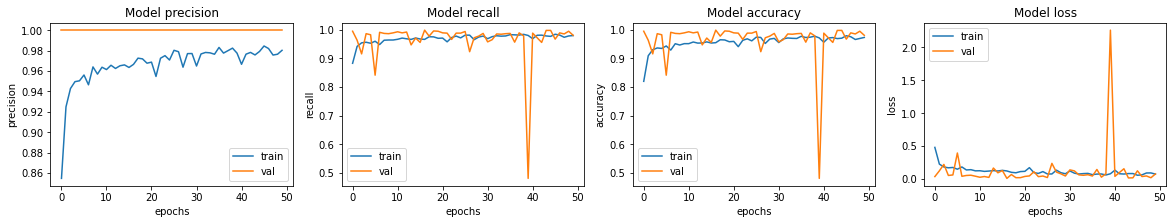

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_base.history[met]) # train
    ax[i].plot(history_base.history['val_' + met]) # validation
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    #ax[i].xlim([0,100])
    ax[i].legend(['train', 'val'])

In [ ]:
# Get predictions

preds_base = model_base.predict(x_test)
#preds_base[preds_base <= 0.5] = 0
#preds_base[preds_base > 0.5] = 1

print(y_test.shape)
print(preds_base.shape)

(624,)
(624, 1)


In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(8,6))
  #sns.heatmap(cm, annot=True, fmt="d")
  plot_confusion_matrix(cm,figsize=(8,6))
  plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
  plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
  plt.title('Confusion matrix with threshold {:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total Pneumonia images: ', np.sum(cm[1]))

True Negatives:  131
False Positives:  103
False Negatives:  5
True Positives:  385
Total Pneumonia images:  390


<Figure size 576x432 with 0 Axes>

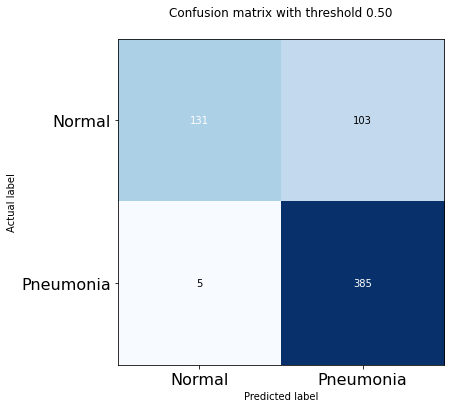

In [ ]:
plot_cm(y_test, preds_base)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  
  model_auc = sklearn.metrics.roc_auc_score(labels, predictions)
  no_pred = np.zeros(len(labels))
  no_fp, no_tp, _ = sklearn.metrics.roc_curve(labels, no_pred)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.plot(100*no_fp, 100*no_tp, linewidth=2, linestyle='--', label="Random",**kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-0.5,20])
  plt.xlim([0,100.5])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  plt.legend(loc='lower right')

  print('Model: ROC AUC=%.3f' % (model_auc))

Model: ROC AUC=0.945


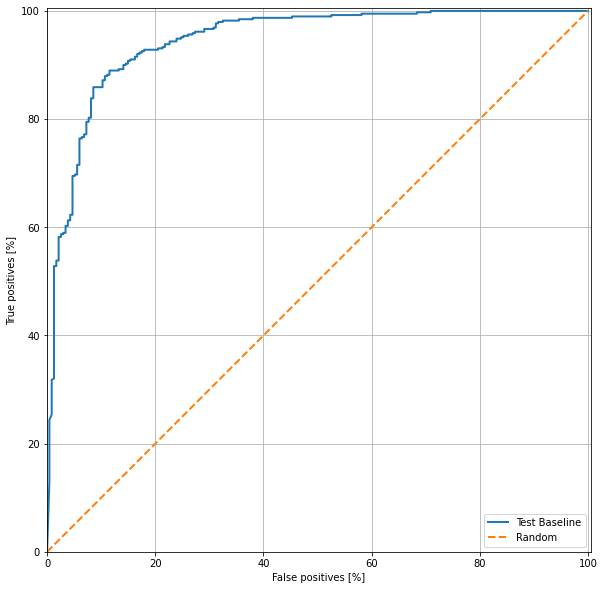

In [ ]:
mpl.rcParams['figure.figsize'] = (10, 10)
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Test Baseline", y_test, preds_base)

## 5. CNN model

Next, I will try 2 different methods:

- Implement a convolutional neural network from scratch. The CNN will draw inspiration from the paper An Efficient Deep Learning Approach to Pneumonia Classification in Healthcare
- Implement a CNN based on DenseNet architecture. This is a similar approach as used in the CheXNet from Stanford.

In addition, Since the data set seems imbalanced, I'll assign some weights to the classes and use them in the loss function.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)

val_datagen = ImageDataGenerator(rescale = 1./255,
                                 validation_split=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
img_size = 150
batch_size = 32
train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    color_mode="rgb", # "grayscale"
    class_mode="binary",
    batch_size= batch_size,
    shuffle=True,
    subset='training'
    )

val_set = val_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    color_mode="rgb", # "grayscale"
    class_mode="binary",
    batch_size=batch_size,
    shuffle = True,
    subset='validation'
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size = (img_size, img_size),
    color_mode="rgb", # "grayscale"
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False # I want the same order as y_test
    )

Found 4200 images belonging to 2 classes.
Found 1049 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
model_CNN = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=3, strides=1, activation="relu",
                           input_shape=[img_size,img_size,3]),
                    layers.MaxPool2D(pool_size=2, strides=2),
                    layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu"),
                    layers.MaxPool2D(pool_size=2, strides=2),
                    layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu"),
                    layers.MaxPool2D(pool_size=2, strides=2),
                    layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu"),
                    layers.MaxPool2D(pool_size=2, strides=2),
                    layers.Flatten(),
                    layers.Dropout(rate=0.5),
                    layers.Dense(units=512, activation="relu"),
                    layers.Dense(units=1, activation="sigmoid")
])

In [ ]:
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
# load weights from pre_model (see 'weight colab notebook') into this model.
model_CNN.load_weights('/content/drive/My Drive/CoronaHack/weightCNN.h5')

In [ ]:
# https://keras.io/api/optimizers/
model_CNN.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=METRICS
    )

CNN_csv_logger = CSVLogger('/content/drive/My Drive/chest_xray/CNN_training.log')

In [ ]:
# get count of normal and pneumonia example to calculate the weights (imbalanced dataset)
normal_path= os.path.join(train_path, "NORMAL")
norm_img = os.listdir(normal_path)
norm_count = len(norm_img)

pneu_path= os.path.join(train_path, "PNEUMONIA")
pneu_img = os.listdir(pneu_path)
pneu_count = len(pneu_img)

tot_train_img = norm_count + pneu_count

In [ ]:
history_CNN = model_CNN.fit(train_set,
                    #steps_per_epoch = tot_train_img //  batch_size,
                    epochs = 50,
                    validation_data = val_set,
                    class_weight = class_weight,
                    callbacks=[CNN_csv_logger]
                    )
#steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
#validation_steps = TotalvalidationSamples / ValidationBatchSize

Epoch 1/50
132/132 [==============================] - 75s 566ms/step - loss: 0.0943 - accuracy: 0.9624 - precision: 0.9612 - recall: 0.9628 - val_loss: 0.0797 - val_accuracy: 0.9600 - val_precision: 0.9973 - val_recall: 0.9485
Epoch 2/50
132/132 [==============================] - 74s 563ms/step - loss: 0.1030 - accuracy: 0.9602 - precision: 0.9887 - recall: 0.9572 - val_loss: 0.0478 - val_accuracy: 0.9781 - val_precision: 0.9947 - val_recall: 0.9755
Epoch 3/50
132/132 [==============================] - 75s 569ms/step - loss: 0.1050 - accuracy: 0.9610 - precision: 0.9894 - recall: 0.9575 - val_loss: 0.1713 - val_accuracy: 0.9380 - val_precision: 0.9986 - val_recall: 0.9175
Epoch 4/50
132/132 [==============================] - 74s 560ms/step - loss: 0.0867 - accuracy: 0.9631 - precision: 0.9881 - recall: 0.9617 - val_loss: 0.0782 - val_accuracy: 0.9628 - val_precision: 0.9960 - val_recall: 0.9536
Epoch 5/50
132/132 [==============================] - 74s 559ms/step - loss: 0.0919 - accura

In [ ]:
model_CNN.save('/content/drive/My Drive/chest_xray/modelCNN.h5')
#model_CNN.save("/content/drive/My Drive/chest_xray")
#history_CNN.history.keys()

In [ ]:
loss, acc, prec, rec = model_CNN.evaluate(test_set)

20/20 [==============================] - 6s 310ms/step - loss: 0.1579 - accuracy: 0.9567 - precision: 0.9595 - recall: 0.9718


In [ ]:
print("Loss of the model is - %.3f" % loss)
print("Accuracy of the model is - %.3f" % acc)
print("Precision of the model is - %.3f" % prec)
print("Recall of the model is - %.3f" % rec)

Loss of the model is - 0.158
Accuracy of the model is - 0.957
Precision of the model is - 0.959
Recall of the model is - 0.972


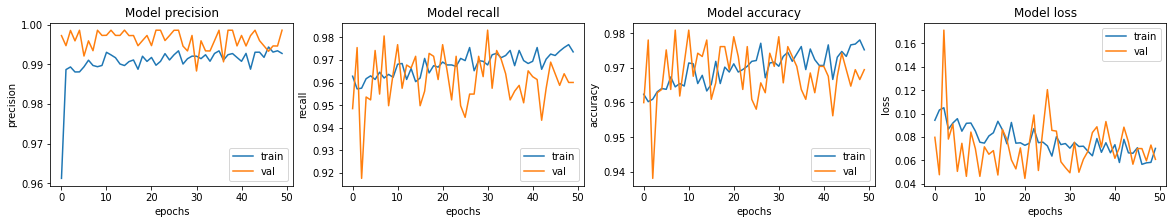

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_CNN.history[met]) # train
    ax[i].plot(history_CNN.history['val_' + met]) # validation
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    #ax[i].xlim([0,100])
    ax[i].legend(['train', 'val'])

In [ ]:
test_set.reset()

In [ ]:
# Get predictions
preds_CNN = model_CNN.predict(test_set)
preds_CNN.shape

(624, 1)

True Negatives:  218
False Positives:  16
False Negatives:  11
True Positives:  379
Total Pneumonia images:  390


<Figure size 576x432 with 0 Axes>

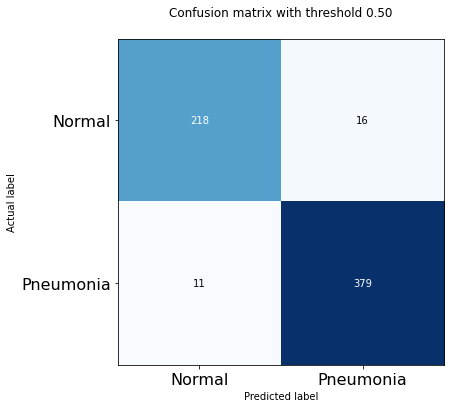

In [ ]:
plot_cm(y_test, preds_CNN)

Model: ROC AUC=0.987


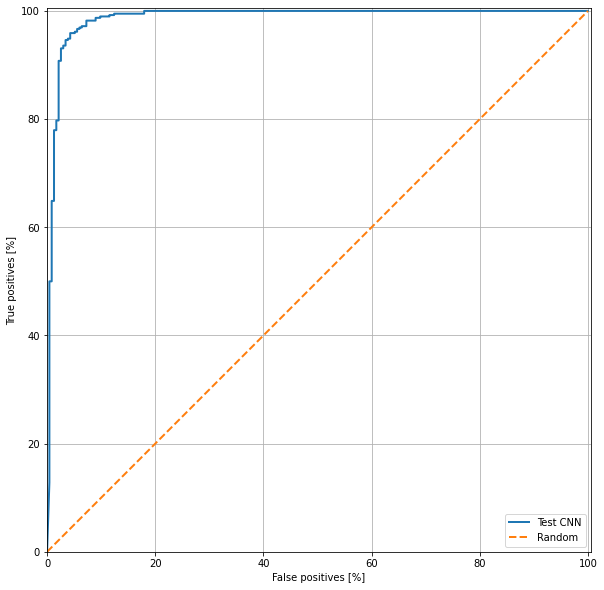

In [ ]:
plot_roc("Test CNN", y_test, preds_CNN)

 ## DenseNet

In [ ]:
#train_set.reset()
#val_set.reset()

In [ ]:
densenet = DenseNet121(
    #weights="imagenet",
    include_top=False,
    input_shape=(img_size,img_size,3),
    classes = 2
)

def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
model_DN = build_model()
#model_DN.trainable = True

model_DN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
# load weights from pre_model (see 'weight colab notebook') into this model.
model_DN.load_weights('/content/drive/My Drive/CoronaHack/weightDN.h5')

In [ ]:
model_DN.compile(
        optimizer=keras.optimizers.Adam(lr=0.00001),
        loss='binary_crossentropy',
        metrics=METRICS
        )

DN_csv_logger = CSVLogger('/content/drive/My Drive/chest_xray/DN_training.log')

In [ ]:
history_DN = model_DN.fit(
    train_set,
    #steps_per_epoch=tot_train_img //  batch_size,
    epochs = 50,
    validation_data = val_set,
    class_weight = class_weight,
    callbacks=[DN_csv_logger]
)

Epoch 1/50
132/132 [==============================] - 82s 622ms/step - loss: 0.0219 - accuracy: 0.9910 - precision: 0.9928 - recall: 0.9886 - val_loss: 0.0081 - val_accuracy: 0.9962 - val_precision: 1.0000 - val_recall: 0.9948
Epoch 2/50
132/132 [==============================] - 79s 599ms/step - loss: 0.0138 - accuracy: 0.9948 - precision: 0.9990 - recall: 0.9939 - val_loss: 0.0171 - val_accuracy: 0.9933 - val_precision: 1.0000 - val_recall: 0.9910
Epoch 3/50
132/132 [==============================] - 79s 600ms/step - loss: 0.0191 - accuracy: 0.9914 - precision: 0.9984 - recall: 0.9900 - val_loss: 0.0249 - val_accuracy: 0.9895 - val_precision: 1.0000 - val_recall: 0.9858
Epoch 4/50
132/132 [==============================] - 79s 596ms/step - loss: 0.0143 - accuracy: 0.9938 - precision: 0.9984 - recall: 0.9932 - val_loss: 0.0154 - val_accuracy: 0.9933 - val_precision: 1.0000 - val_recall: 0.9910
Epoch 5/50
132/132 [==============================] - 79s 598ms/step - loss: 0.0105 - accura

In [ ]:
model_DN.save('/content/drive/My Drive/chest_xray/modelDN.h5')
#model_DN.save("/content/drive/My Drive/chest_xray")

In [ ]:
test_set.reset()
loss, acc, prec, rec = model_DN.evaluate(test_set)

20/20 [==============================] - 7s 366ms/step - loss: 0.1203 - accuracy: 0.9647 - precision: 0.9600 - recall: 0.9846


In [ ]:
print("Loss of the model is - %.3f" % loss)
print("Accuracy of the model is - %.3f" % acc)
print("Precision of the model is - %.3f" % prec)
print("Recall of the model is - %.3f" % rec)

Loss of the model is - 0.120
Accuracy of the model is - 0.965
Precision of the model is - 0.960
Recall of the model is - 0.985


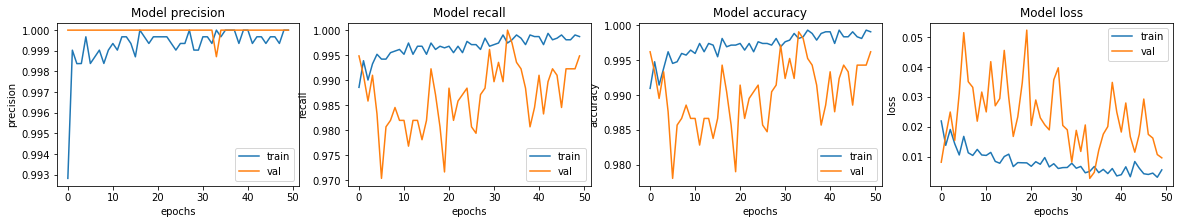

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_DN.history[met]) # train
    ax[i].plot(history_DN.history['val_' + met]) # validation
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    #ax[i].xlim([0,100])
    ax[i].legend(['train', 'val'])

In [ ]:
# Get predictions
test_set.reset()
preds_DN = model_DN.predict(test_set)
preds_DN.shape

(624, 1)

True Negatives:  218
False Positives:  16
False Negatives:  6
True Positives:  384
Total Pneumonia images:  390


<Figure size 576x432 with 0 Axes>

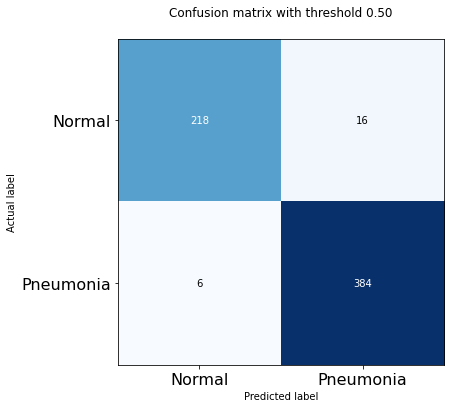

In [ ]:
plot_cm(y_test, preds_DN)

Model: ROC AUC=0.996


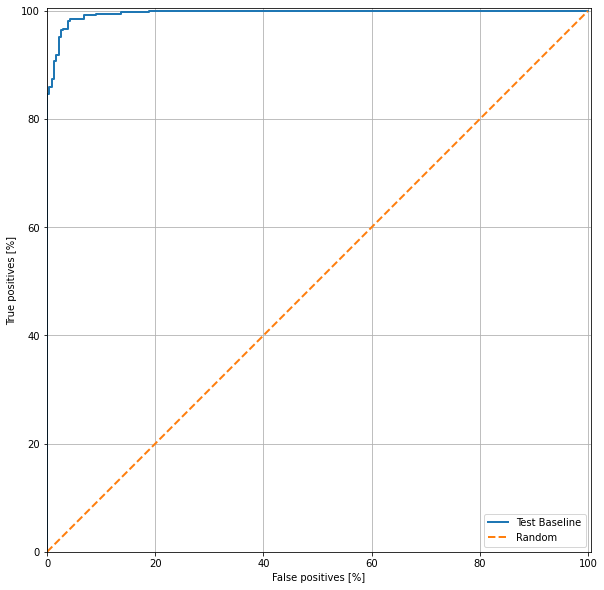

In [ ]:
mpl.rcParams['figure.figsize'] = (10, 10)
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plot_roc("Test Baseline", y_test, preds_DN)
#plt.legend(loc='lower right')